In [826]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import datetime
from statsmodels.stats.power import tt_ind_solve_power
import statsmodels.stats.api as sms

def date_converter(x):
    return datetime.datetime.strptime(x,'%Y-%m-%d')

def print_interval(interval):
    return f"{round((interval[1] + interval[0]) / 2, 2)} ± {round((interval[1] - interval[0]) / 2, 2)}"

### verification_experiment_segment

##### Табличка содержит всех участников эксперимента поделенных на экспериментальные группы

In [827]:
verification_experiment_segment = pd.read_csv('_PUBLIC_services_verification_experiment_segment__202303152121.csv')

In [828]:
verification_experiment_segment.head()

,user_id,experiment_group,UserType,RegistrationTime
0,1085,no_discount,Private,2010-04-03 13:26:41.366
1,1578,no_discount,Private,2010-08-09 10:27:41.001
2,2037,30_discount,Company,2010-10-13 22:07:26.026
3,3586,30_discount,Private,2011-02-11 15:38:06.254
4,4482,no_discount,Private,2011-04-02 14:12:17.220


In [829]:
verification_experiment_segment.shape

(762730, 4)

### Нет NaN-ов

In [830]:
verification_experiment_segment.isna().sum()

user_id             0
experiment_group    0
UserType            0
RegistrationTime    0
dtype: int64

### User_iten_info
##### Таблица с дополнительной информацией об объявлениях

In [831]:
user_item_info = pd.read_csv('user_item_info_202303152224.csv')

In [832]:
user_item_info.head()

,item_id,user_id,item_vertical,item_region,item_creation_time
0,1170914500673,271622000028,6,78,2021-12-04 12:50:50.389
1,1170965250432,342753250052,1,41,NaN
2,1170972500659,397739500055,2,39,2021-12-04 14:57:43.887
3,1170977500699,397739500055,2,15,2021-12-04 15:02:55.334
4,1170962250336,81249500010,3,13,2021-12-04 16:36:28.576


In [833]:
user_item_info.shape

(47231882, 5)

In [834]:
user_item_info.isna().sum()

item_id                     0
user_id                     0
item_vertical               0
item_region                 0
item_creation_time    2708528
dtype: int64

##### Заполним NaN в item_creation_time предыдущим значением

In [835]:
user_item_info.fillna(method='ffill', inplace = True)

In [836]:
user_item_info.head()

,item_id,user_id,item_vertical,item_region,item_creation_time
0,1170914500673,271622000028,6,78,2021-12-04 12:50:50.389
1,1170965250432,342753250052,1,41,2021-12-04 12:50:50.389
2,1170972500659,397739500055,2,39,2021-12-04 14:57:43.887
3,1170977500699,397739500055,2,15,2021-12-04 15:02:55.334
4,1170962250336,81249500010,3,13,2021-12-04 16:36:28.576


In [837]:
user_item_info['item_creation_time'].isna().sum()

0

In [838]:
user_item_info[user_item_info['item_creation_time'] > '2021-09-15']['item_id'].count()

6737175

### services_verification_discount

##### Табличка содержит факт прохождения верификации пользователей из эксперимента. Указывается дата и объявления, на которые пользователь получил скидку.

In [839]:
services_verification_discount = pd.read_csv('services_verification_discounts_202303152133.csv')

In [840]:
services_verification_discount.head()

,user_id,item_id,discount_day,experiment
0,49000737,11352751363,2021-10-01,1_verification_test
1,4255271,78048500109,2021-10-10,1_verification_test
2,111000153,101676750179,2021-10-02,1_verification_test
3,110750728,162344000369,2021-10-14,1_verification_test
4,143655000006,252307750608,2021-10-09,1_verification_test


In [841]:
services_verification_discount.isna().sum()

user_id         0
item_id         0
discount_day    0
experiment      0
dtype: int64

### user_payments_info

##### Таблица содержит информацию о совершенных покупках услуг Авито для работы с объявлениями. Важно. Наличие скидки никак не отмечается в транзакциях

In [842]:
user_payments_info = pd.read_csv('user_payments_info_202303152221.csv')

In [843]:
user_payments_info.head()

,user_id,item_id,event_time,transaction_type,transaction_subtype,amount_net
0,193193750074,4.116165e+11,2021-07-18 10:10:36.000,3,16,21.000000
1,193193750074,4.116165e+11,2021-07-27 12:44:32.000,3,16,26.923077
2,218661250010,4.112775e+11,2021-07-08 16:14:48.000,3,17,84.692308
3,91246750001,4.115513e+11,2021-07-22 10:48:32.000,3,17,61.538462
4,91246750001,4.115513e+11,2021-07-22 10:48:47.000,3,17,61.538462


In [844]:
user_payments_info.shape

(7739054, 6)

In [845]:
user_payments_info.query("event_time > '2021-09-15'").isna().sum()

user_id                    0
item_id                67042
event_time                 0
transaction_type           0
transaction_subtype        0
amount_net                 0
dtype: int64

In [846]:
user_payments_info[user_payments_info['item_id'].isna()].head()

,user_id,item_id,event_time,transaction_type,transaction_subtype,amount_net
43841,1265957,NaN,2021-07-03 00:06:40.108,1,7,27.307692
43874,651774000040,NaN,2021-07-06 00:11:21.509,1,6,19.615385
92906,159250168,NaN,2021-07-01 00:02:06.394,1,6,22.076923
225470,572457500002,NaN,2021-07-14 00:05:28.750,1,7,22.153846
254720,293750121,NaN,2021-07-01 00:09:51.681,1,7,27.307692


In [847]:
user_payments_info.query("transaction_type == 1 & transaction_subtype == 7").shape

(62421, 6)

In [848]:
user_payments_info.query("transaction_type == 1 & transaction_subtype == 7").isna().sum()

user_id                    0
item_id                62421
event_time                 0
transaction_type           0
transaction_subtype        0
amount_net                 0
dtype: int64

Видимо какие-то типы транзакций не привязаны к товару, заполним "no_item"

In [849]:
user_payments_info.replace({np.nan: "no_item"}, inplace=True)

## Проверка на корректность разбиения групп перед тестом 

#### Так как здесь буду проверять сразу несколько гипотез, то уровень значимости выставлю $\alpha = 0.01$ чтобы не завышать ошибку первого рода

### 1. Проверяю пропорции юзеров, у которых уже был опыт покупки услуг продвижени на предпериоде 


$H_0: proportion_{nodisc} = proportion_{30disc} = proportion_{60disc}$

$H_1: proportion_{nodisc} \neq proportion_{30disc} \neq proportion_{60disc}$

##### Здесь и в дальнейшем проверяю эту гипотезу как 3 попарных сравнения

In [850]:
payments_by_user_on_pred = user_payments_info.query("event_time < '2021-09-15'")[['user_id', 'amount_net']].groupby(['user_id']).sum()

In [851]:
had_payments_on_pred = pd.merge(verification_experiment_segment, payments_by_user_on_pred, on='user_id', how='left')
had_payments_on_pred.head()

,user_id,experiment_group,UserType,RegistrationTime,amount_net
0,1085,no_discount,Private,2010-04-03 13:26:41.366,NaN
1,1578,no_discount,Private,2010-08-09 10:27:41.001,NaN
2,2037,30_discount,Company,2010-10-13 22:07:26.026,NaN
3,3586,30_discount,Private,2011-02-11 15:38:06.254,NaN
4,4482,no_discount,Private,2011-04-02 14:12:17.220,227.615385


In [852]:
had_payments_on_pred['had_payments'] = had_payments_on_pred['amount_net'].replace({np.nan: False}).astype('bool').astype('int')

In [853]:
group_no_discount = had_payments_on_pred.query("experiment_group == 'no_discount'")['had_payments']
group_30_discount = had_payments_on_pred.query("experiment_group == '30_discount'")['had_payments']
group_60_discount = had_payments_on_pred.query("experiment_group == '60_discount'")['had_payments']

In [854]:
print(f'group_no_discount mean: {group_no_discount.mean()}, group_30_discount mean: {group_30_discount.mean()}, group_60_discount mean: {group_60_discount.mean()}')

group_no_discount mean: 0.3366206880364282, group_30_discount mean: 0.3358984164028652, group_60_discount mean: 0.33677660678422194


In [855]:
print(ttest_ind(group_no_discount, group_30_discount),'\n',
ttest_ind(group_60_discount, group_30_discount),'\n',
ttest_ind(group_60_discount, group_no_discount))

Ttest_indResult(statistic=0.545521483631751, pvalue=0.5853951478044056) 
 Ttest_indResult(statistic=0.6618281880558387, pvalue=0.5080816394890297) 
 Ttest_indResult(statistic=0.11769958900972477, pvalue=0.9063057388758138)


##### Статзначимого различия в группах нет 

### 2. Выручка с платящих пользователей на предпериоде 

$H_0: ARPPU_{nodisc} = ARPPU_{30disc} = ARPPU_{60disc}$

$H_1: ARPPU_{nodisc} \neq ARPPU_{30disc} \neq ARPPU_{60disc}$

In [856]:
payments_by_user_on_pred = user_payments_info.query("event_time < '2021-09-15'")[['user_id', 'amount_net']].groupby(['user_id']).sum()

In [857]:
payments_on_pred = pd.merge(verification_experiment_segment, payments_by_user_on_pred, on='user_id', how='left')
payments_on_pred.dropna(inplace=True)
payments_on_pred.head()

,user_id,experiment_group,UserType,RegistrationTime,amount_net
4,4482,no_discount,Private,2011-04-02 14:12:17.220,227.615385
6,8836,30_discount,Private,2011-11-14 21:57:20.547,54.307692
7,11161,60_discount,Company,2012-02-17 23:27:52.058,3973.076923
8,11340,no_discount,Private,2012-02-23 20:35:10.315,26.384615
10,13475,no_discount,Company,2012-05-05 18:55:05.330,1195.846154


In [858]:
group_no_discount = payments_on_pred.query("experiment_group == 'no_discount'")['amount_net']
group_30_discount = payments_on_pred.query("experiment_group == '30_discount'")['amount_net']
group_60_discount = payments_on_pred.query("experiment_group == '60_discount'")['amount_net']

In [859]:
print(f'group_no_discount mean: {group_no_discount.mean()}, group_30_discount mean: {group_30_discount.mean()}, group_60_discount mean: {group_60_discount.mean()}')

group_no_discount mean: 521.8628421641694, group_30_discount mean: 482.25909929446186, group_60_discount mean: 502.8373086340979


In [860]:
print(ttest_ind(group_no_discount, group_30_discount),'\n',
ttest_ind(group_60_discount, group_30_discount),'\n',
ttest_ind(group_60_discount, group_no_discount))

Ttest_indResult(statistic=1.4010062526790747, pvalue=0.16121401538204816) 
 Ttest_indResult(statistic=1.0959257896199406, pvalue=0.27311279936025384) 
 Ttest_indResult(statistic=-0.6478772386094245, pvalue=0.5170652213163272)


## Вывод: группы однородны по выручке на пользователя и по количеству покупавших услуги продвижения пользователей на пердпериоде 

#### Хочу посмотреть конверсии в верификацию по группам

In [861]:
services_verification_discount

,user_id,item_id,discount_day,experiment
0,49000737,11352751363,2021-10-01,1_verification_test
1,4255271,78048500109,2021-10-10,1_verification_test
2,111000153,101676750179,2021-10-02,1_verification_test
3,110750728,162344000369,2021-10-14,1_verification_test
4,143655000006,252307750608,2021-10-09,1_verification_test
...,...,...,...,...
29958,65500899,1129535751173,2021-09-25,1_verification_test
29959,830210750056,1129550000127,2021-09-30,1_verification_test
29960,368182337,1129612500421,2021-09-30,1_verification_test
29961,399483500082,1130392750186,2021-09-27,1_verification_test


In [862]:
services_verification_discount.groupby(['user_id']).count()

,item_id,discount_day,experiment
user_id,,,
101,1,1,1
789,1,1,1
958,1,1,1
1379,1,1,1
1687,1,1,1
...,...,...,...
922358000021,1,1,1
922358250048,1,1,1
922374750066,1,1,1


#### В таблице о прохождении верификации дублируются даты выдачи скидки для каждого объявления пользователя 

In [863]:
services_verification_discount.groupby(['user_id']).count().query("item_id > 1")['item_id'].unique()

array([  3,   2,   4,   9,  10,   7,  15,   5,  12,  17,   8,  37,  34,
         6,  32,  26, 109, 312,  11,  21,  30,  38,  20,  27,  51,  28,
        25,  13,  54,  35,  41,  95,  18,  14,  19,  29,  16,  58,  23,
        42,  44,  24,  59,  31,  60,  61,  40,  50], dtype=int64)

In [864]:
services_verification_discount.groupby(['user_id']).count().query("item_id > 1 & item_id == 312")

,item_id,discount_day,experiment
user_id,,,
368014725,312,312,312


In [865]:
services_verification_discount.query("user_id == 368014725")

,user_id,item_id,discount_day,experiment
388,368014725,683069500046,2021-09-23,1_verification_test
391,368014725,684253250145,2021-09-23,1_verification_test
393,368014725,684509251605,2021-09-23,1_verification_test
442,368014725,781626000108,2021-09-23,1_verification_test
444,368014725,782405000191,2021-09-23,1_verification_test
...,...,...,...,...
29493,368014725,802224500002,2021-09-23,1_verification_test
29494,368014725,802237000043,2021-09-23,1_verification_test
29495,368014725,802254000163,2021-09-23,1_verification_test
29496,368014725,802887750084,2021-09-23,1_verification_test


Запись о верификации добавляется для каждого айтема юзера, уберу айтем и дропну дубликаты

In [866]:
discount_no_duplicates = services_verification_discount[['user_id', 'discount_day']].drop_duplicates()

-----

## Здесь начинается тело теста 

### Планирование

#### Хочу смотреть две метрики 
- Конверсия в верификацию 
- *ARPU* по верифицирующимся 

#### Ожидания
- Конверсия больше, чем больше скидка
- Кажется что просядем по выручке из-за скидок 

Скорее всего будет трейдоф по конверсии и  *ARPU*

---------

In [867]:
for_plot = user_payments_info[['event_time', 'amount_net']].copy()
for_plot.event_time = pd.to_datetime(for_plot.event_time).round('D')
for_plot = for_plot[['event_time', 'amount_net']].groupby('event_time').sum().reset_index()

Доходы по дням, видим что есть недельная сезонность

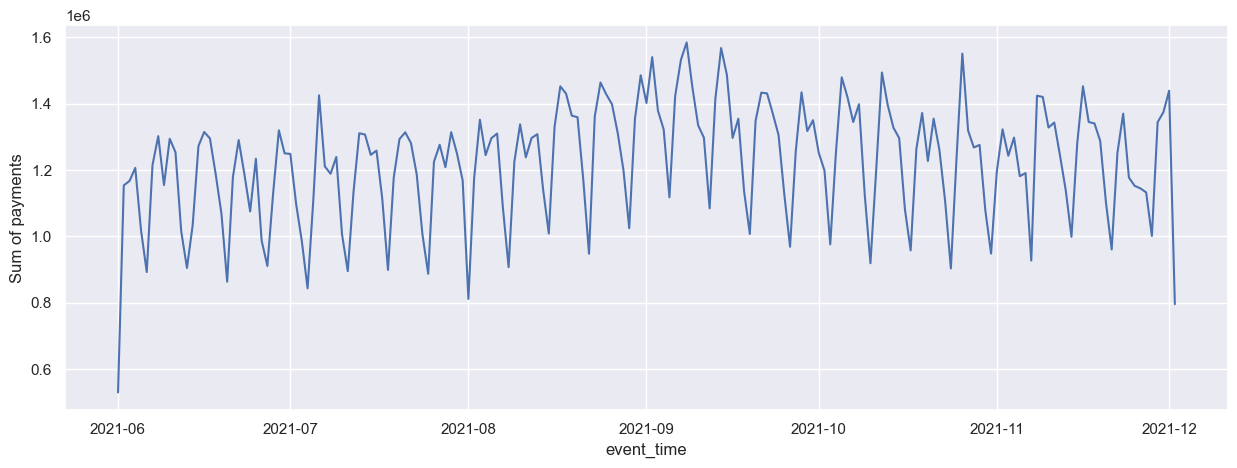

In [868]:
plt.figure(figsize=(15, 5))
plt.plot(for_plot.event_time, for_plot.amount_net)
plt.xlabel('event_time')
plt.ylabel('Sum of payments')
plt.show()

In [869]:
df_for_plan = user_payments_info[['user_id', 'event_time', 'amount_net']].copy()
df_for_plan.event_time = pd.to_datetime(df_for_plan.event_time).round('D')

In [870]:
df_for_plan.head()

,user_id,event_time,amount_net
0,193193750074,2021-07-18,21.000000
1,193193750074,2021-07-28,26.923077
2,218661250010,2021-07-09,84.692308
3,91246750001,2021-07-22,61.538462
4,91246750001,2021-07-22,61.538462


In [871]:
df_for_plan.event_time.min(), df_for_plan.event_time.max()

(Timestamp('2021-06-01 00:00:00'), Timestamp('2021-12-02 00:00:00'))

Здесь я считаю какой относительный *MDE*, который мы можем получить за время действия теста 

In [872]:
def choose_date(data, start_date, delta, share): 
    tmp = data[(data.event_time>=start_date)&(data.event_time<=start_date+datetime.timedelta(days=delta))]

    payments_pred = pd.merge(verification_experiment_segment, tmp, on=['user_id'], how='left')
    payments_pred = payments_pred[['user_id', 'event_time', 'amount_net']]
    payments_pred.event_time = pd.to_datetime(payments_pred.event_time.fillna('2021-06-01'))
    payments_pred.amount_net = payments_pred.amount_net.fillna(0)

    tmp=payments_pred.groupby(['user_id']).sum().reset_index()
    x = tmp[(tmp.user_id)%100<=int(100*share)].reset_index()
    return x

In [873]:
for result_effect in np.linspace(0.01, 0.20, 20).round(2):
    x1 =choose_date(df_for_plan, datetime.datetime(2021, 6, 1, 0, 0), 90, 0.33) #получаем необходимую подвыборку

    mean = x1.amount_net.mean()
    std = x1.amount_net.std()

    alpha = 0.01
    power = 0.8
    # result_effect = 0.15 # целевой размер относительного отклоенения исходной метрики
    effect_size = (mean / std) * result_effect

    num_obs = tt_ind_solve_power(effect_size=effect_size, alpha = alpha, power = power, ratio=1.0, alternative='two-sided')

    print(f"For result_effect = {result_effect}, we need to enlarge number of observations in {round((num_obs / x1.shape[0]), 3)} times")

For result_effect = 0.01, we need to enlarge number of observations in 341.663 times
For result_effect = 0.02, we need to enlarge number of observations in 85.416 times
For result_effect = 0.03, we need to enlarge number of observations in 37.963 times
For result_effect = 0.04, we need to enlarge number of observations in 21.354 times
For result_effect = 0.05, we need to enlarge number of observations in 13.667 times
For result_effect = 0.06, we need to enlarge number of observations in 9.491 times
For result_effect = 0.07, we need to enlarge number of observations in 6.973 times
For result_effect = 0.08, we need to enlarge number of observations in 5.338 times
For result_effect = 0.09, we need to enlarge number of observations in 4.218 times
For result_effect = 0.1, we need to enlarge number of observations in 3.417 times
For result_effect = 0.11, we need to enlarge number of observations in 2.824 times
For result_effect = 0.12, we need to enlarge number of observations in 2.373 times

#### Соответственно при выбранных параметрах $\alpha=0.01, power=0.8$ и допустимом времени эксперимента в 90 дней $\newline$ мы сможем отловить относительный MDE только в 19%, или меньший, но уже с меньшей мощностью 
#### При этом в самом эксперименте мы будем смотреть только на верифицровавшихся пользователей 

-------------------------

### Сравниваю конверсии в верификацию на конец эксперимента

$H_0: Conversion_{nodisc} = Conversion_{30disc} = Conversion_{60disc}$

$H_1: Conversion_{nodisc} \neq Conversion_{30disc} \neq Conversion_{60disc}$

In [874]:
verification_in_groups = pd.merge(verification_experiment_segment, discount_no_duplicates, on='user_id', how='left')
verification_in_groups['is_verificated'] = verification_in_groups['discount_day'].replace({np.nan: False}).astype('bool').astype('int')

In [875]:
verification_in_groups.head()

,user_id,experiment_group,UserType,RegistrationTime,discount_day,is_verificated
0,1085,no_discount,Private,2010-04-03 13:26:41.366,NaN,0
1,1578,no_discount,Private,2010-08-09 10:27:41.001,NaN,0
2,2037,30_discount,Company,2010-10-13 22:07:26.026,2021-10-07,1
3,3586,30_discount,Private,2011-02-11 15:38:06.254,NaN,0
4,4482,no_discount,Private,2011-04-02 14:12:17.220,NaN,0


In [876]:
group_no_discount = verification_in_groups.query("experiment_group == 'no_discount'")['is_verificated']
group_30_discount = verification_in_groups.query("experiment_group == '30_discount'")['is_verificated']
group_60_discount = verification_in_groups.query("experiment_group == '60_discount'")['is_verificated']

In [877]:
print(f'group_no_discount mean: {group_no_discount.mean()}, group_30_discount mean: {group_30_discount.mean()}, group_60_discount mean: {group_60_discount.mean()}')

group_no_discount mean: 0.026847816732257283, group_30_discount mean: 0.029511479752743788, group_60_discount mean: 0.0327886963829846


In [878]:
print(ttest_ind(group_30_discount, group_no_discount),'\n',
ttest_ind(group_60_discount, group_30_discount),'\n',
ttest_ind(group_60_discount, group_no_discount))

Ttest_indResult(statistic=5.744066609782671, pvalue=9.24817641186568e-09) 
 Ttest_indResult(statistic=6.717218771897073, pvalue=1.8541994120549372e-11) 
 Ttest_indResult(statistic=12.464991483226907, pvalue=1.1728381169824205e-35)


In [879]:
group_no_discount_sm, group_60_discount_sm = sms.DescrStatsW(group_no_discount), sms.DescrStatsW(group_60_discount)
cm = sms.CompareMeans(group_60_discount_sm, group_no_discount_sm)
interval = print_interval(np.array(cm.tconfint_diff(alpha=0.01)) / group_no_discount.mean()) 
print(f"Relative CI for grops no_discount and 60_discount {interval}")

Relative CI for grops no_discount and 60_discount 0.22 ± 0.05


### Все тесты прокрасились $C_{nodisc} < C_{30disc} < C_{60disc}$

---------------------------------------

### Хочу посмотреть средний доход на пользователя на конец эксперимента

$H_0: ARPU_{nodisc} =ARPU_{30disc} = ARPU_{60disc}$

$H_1: ARPU_{nodisc} \neq ARPU_{30disc} \neq ARPU_{60disc}$

In [880]:
payments_after_verification = pd.merge(services_verification_discount, user_payments_info.query("event_time > '2021-09-15' & item_id != 'no_item'"), on=['user_id', 'item_id'], how='left')

In [881]:
payments_after_verification['event_time'] = payments_after_verification['event_time'].fillna('2049-11-08')
payments_after_verification = payments_after_verification.fillna(0)

In [882]:
payments_after_verification.head()

,user_id,item_id,discount_day,experiment,event_time,transaction_type,transaction_subtype,amount_net
0,49000737,11352751363,2021-10-01,1_verification_test,2021-11-08 08:36:05.000,4.0,3.0,36.615385
1,49000737,11352751363,2021-10-01,1_verification_test,2021-10-08 11:54:09.000,4.0,3.0,36.615385
2,4255271,78048500109,2021-10-10,1_verification_test,2021-10-09 14:54:17.000,4.0,3.0,68.846154
3,111000153,101676750179,2021-10-02,1_verification_test,2049-11-08,0.0,0.0,0.000000
4,110750728,162344000369,2021-10-14,1_verification_test,2049-11-08,0.0,0.0,0.000000


Считаем ARPU

In [883]:
payments_after_verification = payments_after_verification.query("event_time >= discount_day")
payments_after_verification_aggregated = payments_after_verification.groupby('user_id').sum().reset_index()[['user_id', 'amount_net']]
payments_after_verification_aggregated = pd.merge(payments_after_verification_aggregated, verification_experiment_segment[['user_id', 'experiment_group', 'UserType']], on = 'user_id', how='left')

In [884]:
payments_after_verification_aggregated.head()

,user_id,amount_net,experiment_group,UserType
0,101,0.000000,no_discount,Private
1,789,0.000000,30_discount,Private
2,958,0.000000,60_discount,Private
3,1379,0.000000,30_discount,Company
4,1687,107.692308,60_discount,Private


### Средний доход на пользователя после верификации 

In [885]:
group_no_discount = payments_after_verification_aggregated.query("experiment_group == 'no_discount'")['amount_net']
group_30_discount = payments_after_verification_aggregated.query("experiment_group == '30_discount'")['amount_net']
group_60_discount = payments_after_verification_aggregated.query("experiment_group == '60_discount'")['amount_net']

In [886]:
print(f'group_no_discount mean: {group_no_discount.mean()}, group_30_discount mean: {group_30_discount.mean()}, group_60_discount mean: {group_60_discount.mean()}')

group_no_discount mean: 103.32683639143731, group_30_discount mean: 142.25061916578045, group_60_discount mean: 154.09383559012775


In [887]:
print(ttest_ind(group_no_discount, group_30_discount),'\n',
ttest_ind(group_60_discount, group_30_discount),'\n',
ttest_ind(group_60_discount, group_no_discount))

Ttest_indResult(statistic=-4.09232283550769, pvalue=4.295203004153962e-05) 
 Ttest_indResult(statistic=1.2624701930728297, pvalue=0.20679905333452459) 
 Ttest_indResult(statistic=6.317502780398883, pvalue=2.7355739902509427e-10)


In [888]:
group_no_discount_sm, group_60_discount_sm = sms.DescrStatsW(group_no_discount), sms.DescrStatsW(group_60_discount)
cm = sms.CompareMeans(group_60_discount_sm, group_no_discount_sm)
interval = print_interval(np.array(cm.tconfint_diff(alpha=0.01)) / group_no_discount.mean()) 
print(f"Relative CI for grops no_discount and 60_discount {interval}")

Relative CI for grops no_discount and 60_discount 0.49 ± 0.2


#### Один тест не прокрасился

##### $ARPU_{nodisc} < ARPU_{30disc} = ARPU_{60disc}$

#### *А если использовать CUPED*

In [889]:
payments_on_pred = had_payments_on_pred[['user_id', 'amount_net']].fillna(0)

In [890]:
df_for_cuped = pd.merge(payments_after_verification_aggregated, payments_on_pred, how='left', on='user_id')
df_for_cuped

,user_id,amount_net_x,experiment_group,UserType,amount_net_y
0,101,0.000000,no_discount,Private,384.769231
1,789,0.000000,30_discount,Private,235.846154
2,958,0.000000,60_discount,Private,0.000000
3,1379,0.000000,30_discount,Company,233.846154
4,1687,107.692308,60_discount,Private,0.000000
...,...,...,...,...,...
21706,922358000021,0.000000,30_discount,Private,0.000000
21707,922358250048,0.000000,30_discount,Private,0.000000
21708,922374750066,0.000000,no_discount,Private,0.000000
21709,922376500042,0.000000,30_discount,Private,0.000000


In [891]:
df_for_cuped.rename(columns={'amount_net_x': 'amount_net',
                                'amount_net_y':'amount_net_pred'}, inplace=True)

theta = np.cov(df_for_cuped['amount_net'], df_for_cuped['amount_net_pred'], ddof=1)[0,1] / np.var(df_for_cuped['amount_net_pred'], ddof=1)
df_for_cuped['cuped'] = df_for_cuped['amount_net'] - theta * (df_for_cuped['amount_net_pred'] - df_for_cuped['amount_net_pred'].mean())

In [892]:
theta

0.019950830664191097

In [893]:
df_for_cuped.amount_net.mean(), df_for_cuped.cuped.mean(), df_for_cuped.amount_net.var(), df_for_cuped.cuped.var()

(134.8950217365887, 134.8950217365887, 292157.12835218915, 284574.8460976471)

##### :\ здесь *CUPED* особо не поможет, нет сильной корреляции с предериодом

### Оказалось что за счет скидки юзеры покупают более дорогие услуги -> ARPU выше где скидка выше

--------

### Тут я хочу посмотреть как зависит конверсия в верификацию от суммы покупок на предпериоде
#### Для этого делю пользователей с предпериода на группы разбивкой по квантилям

In [894]:
payments_on_pred_verificated = pd.merge(had_payments_on_pred, discount_no_duplicates, how='left', on='user_id')
payments_on_pred_verificated['verificated'] = had_payments_on_pred_verificated['discount_day'].replace({np.nan: False}).astype('bool').astype('int')

In [895]:
payments_on_pred_verificated = payments_on_pred_verificated[['user_id', 'experiment_group', 'amount_net', 'verificated']]
payments_on_pred_verificated = payments_on_pred_verificated.fillna(0)

В группе *zero_payments* нет покупок, нахожу последний квантиль для этой группы

In [896]:
zeros_quantile = payments_on_pred_verificated.query("amount_net == 0").shape[0] / payments_on_pred_verificated.shape[0]
zeros_quantile = round(zeros_quantile, 2)

In [897]:
zero_payments = payments_on_pred_verificated.query("amount_net == 0").groupby(['experiment_group']).mean().reset_index()# .sort_values(by='verificated')
zero_payments['quantile_left'] = 0
zero_payments['quantile_right'] = zeros_quantile
zero_payments.rename(columns={'amount_net': 'mean_amount_net', 'verificated': 'mean_verificated', }, inplace=True)
zero_payments.drop('user_id', inplace=True, axis=1)
zero_payments = zero_payments[['quantile_left', 'quantile_right', 'experiment_group', 'mean_amount_net', 'mean_verificated']]

Здесь разбиваю по квантилям и считаю *verification rate* и *ARPU* в квантильных группах + разбивка по группам эксперимента

In [898]:
segments = [0, zeros_quantile] + list(np.linspace(0.79, 1, num=8).round(2))
df = payments_on_pred_verificated.copy()
df_for_plot = pd.DataFrame(columns=['quantile_left', 'quantile_right', 'experiment_group', 'mean_amount_net', 'mean_verificated'])
df_for_plot = pd.concat([zero_payments, df_for_plot], ignore_index=True)

for pos in range(1, len(segments[:])):
    df_to_print = df[(df.amount_net < df.amount_net.quantile(segments[pos])) & (df.amount_net > df.amount_net.quantile(segments[pos-1]))].copy()
    df_to_print = df_to_print.groupby(['experiment_group']).mean().reset_index().sort_values(by='verificated')
    
    for group in df_to_print.experiment_group.unique():
        group_means = df_to_print[df_to_print.experiment_group == group]
        # print(f'beetween quantiles {segments[pos-1]:.3f}, and {segments[pos]:.3f} in group {group}, mean amount_net: {group_means.amount_net.values[0]:.3f}, verificated: {group_means.verificated.values[0]:.3f}')
        stats = pd.DataFrame([[segments[pos-1], segments[pos], group, group_means.amount_net.values[0], group_means.verificated.values[0]]], columns=df_for_plot.columns)
        df_for_plot = pd.concat([df_for_plot, stats], ignore_index=True)
    # print()

In [899]:
df_for_plot.quantile_left = df_for_plot.quantile_left.astype('float64')
df_for_plot['quantiles'] = df_for_plot.quantile_left.astype('str') + ' - ' + df_for_plot.quantile_right.astype('str')
df_for_plot

,quantile_left,quantile_right,experiment_group,mean_amount_net,mean_verificated,quantiles
0,0.00,0.66,30_discount,0.000000,0.015559,0.0 - 0.66
1,0.00,0.66,60_discount,0.000000,0.016027,0.0 - 0.66
2,0.00,0.66,no_discount,0.000000,0.017172,0.0 - 0.66
3,0.66,0.79,no_discount,40.100983,0.029221,0.66 - 0.79
4,0.66,0.79,30_discount,40.156272,0.035558,0.66 - 0.79
5,0.66,0.79,60_discount,40.224083,0.039767,0.66 - 0.79
6,0.79,0.82,30_discount,82.233758,0.040308,0.79 - 0.82
7,0.79,0.82,no_discount,82.211298,0.040425,0.79 - 0.82
8,0.79,0.82,60_discount,82.252400,0.050579,0.79 - 0.82
9,0.82,0.85,no_discount,111.326173,0.040949,0.82 - 0.85


In [900]:
df_for_plot = pd.merge(df_for_plot, df_for_plot.groupby('quantiles').mean().reset_index()[['mean_amount_net', 'quantiles']], how='left', on='quantiles')
df_for_plot = df_for_plot[['quantiles', 'experiment_group', 'mean_amount_net_y', 'mean_verificated']].rename(columns={'mean_amount_net_y': 'mean_amount_net'})

*Verification rate* по квантильным группам дохода и экспериментальной группе

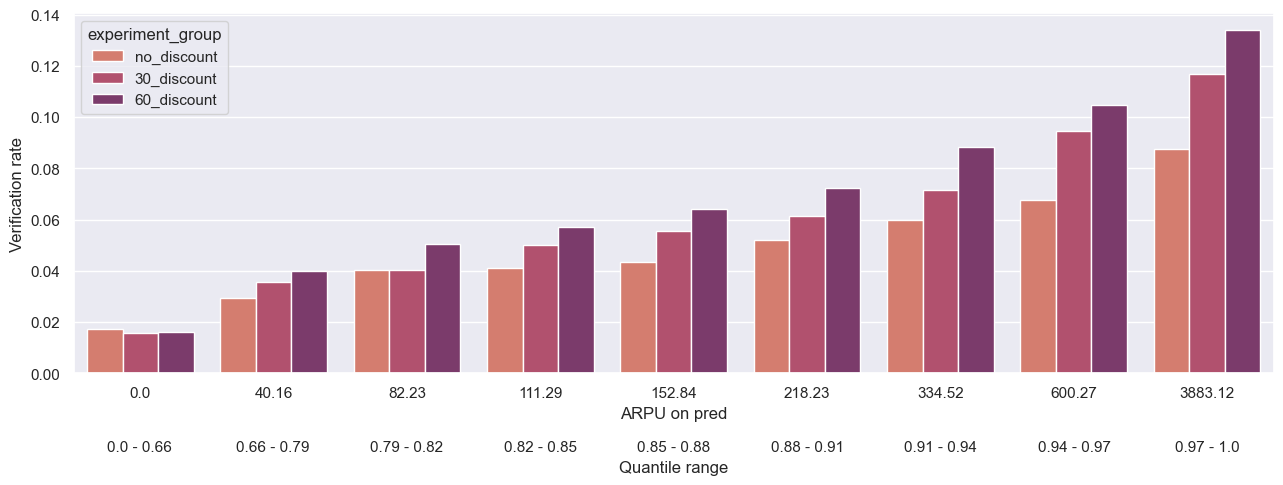

In [901]:
fig = plt.figure(figsize=(15, 6))
ax1 = fig.add_axes((0.1, 0.25, 0.8, 0.6))
hue_order = ['no_discount', '30_discount', '60_discount']
sns.barplot(data = df_for_plot, x = df_for_plot.mean_amount_net.round(2) , y=df_for_plot.mean_verificated, hue = 'experiment_group', hue_order=hue_order, palette="flare", ax=ax1)
ax1.set_xlabel(r"ARPU on pred")

ax1.set_ylabel('Verification rate')
ax2 = fig.add_axes((0.1, 0.16, 0.8, 0))
ax2.yaxis.set_visible(False)

new_tick_locations = np.linspace(0.055, 0.945, 9)

ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(df_for_plot.quantiles.unique())
ax2.set_xlabel(r"Quantile range")
plt.show()

#### Чем выше траты на предпериоде, тем выше конверсия в верификацию, что логично$\newline$ больше тратят <-> более активные юзеры -> больше хоятят скидку и значок

In [902]:
user_type_seg = verification_in_groups.groupby(['UserType', 'experiment_group']).mean().reset_index()

*Verification rate* по типу юзера и экспериментальной группе

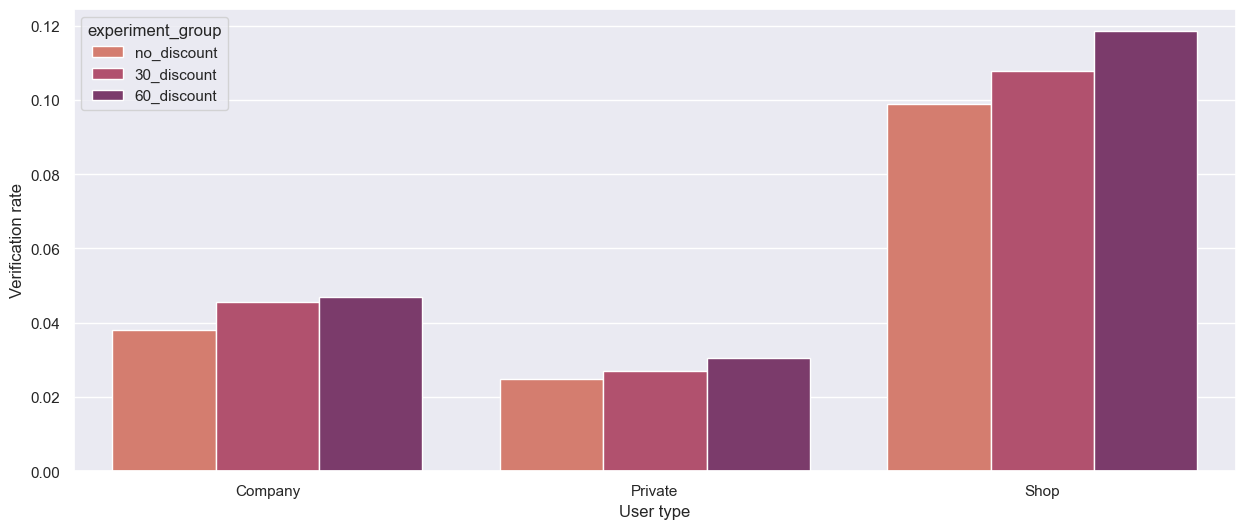

In [903]:
fig = plt.figure(figsize=(15, 6))
sns.barplot(data=user_type_seg, x='UserType', y='is_verificated', hue='experiment_group', hue_order = hue_order, palette="flare")
plt.xlabel('User type')
plt.ylabel('Verification rate')
plt.show()

## Выводы

- **Конверсия** в верификацию самая большая в группе с 60% скидкой, раскатывая этот вариант мы получаем прирост конверсии на **22% ± 5%** в сравнении с группой без скидки
- **ARPU** на верефицированного пользователя наибольшее также в группе с 60% скидкой, раскатив этот вариант мы получим прирост выручки на **49% ± 20%** в сравнении с группой без скидки
- Чем больше пользоваетль тратит на услуги продвижения, тем активнее он верифицируется. $\newline$
  В частности самый большой показатель конверсии у типа пользователей Shop так как они больше всех тратят, самый низкий у частников
- **Предложение с 60% скидкой имеет самую большую конверсию, при этом еще и зарабатывает больше всех денег. $\newline$ Можно спокойно выкатывать на 100% пользователей этой вертикали**
